<a href="https://colab.research.google.com/github/Migaalee/Deep_learning/blob/main/DeepNeuralNetworks_Migla.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2 - ADNE 2022

## Deep neural networks using audio data 

### Aims

The main aim of this project is optimise several deep neural networks for audio files. 

FeedForward neural network

- Bla

Recurrent neural network

- bla

Convolutional neural network 

- bla


Transformers

-bla


### How this works
This file is a [Jupyter Notebook](https://jupyter.org). 
It has instructions, and also code cells. The code cells are connected to Python, and you can run all of the code in a cell by pressing Play (▶) icon in the top bar, or pressing `shift + return`.
The code libraries you should need are already installed.


## Data pre-processing

### Import all required libraries

In [63]:
import glob
import numpy as np
import tensorflow as tf
from google.colab import files
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import matplotlib.pyplot as plt


#auth.authenticate_user()
#gauth = GoogleAuth()
#gauth.credentials = GoogleCredentials.get_application_default()
#drive = GoogleDrive(gauth)
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')
import io
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import mean_absolute_error
sns.set()
from tensorflow import keras
from datetime import datetime
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model, Sequential
from keras.constraints import maxnorm
from tensorflow.keras.layers import Input, BatchNormalization, MaxPooling2D, Flatten, Conv2D, Dense, Activation, Dropout, concatenate, Reshape, UpSampling1D, Conv1D, MaxPooling1D
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow.keras.layers import TimeDistributed,Input, Reshape, UpSampling1D, Conv1D
from keras.layers.recurrent import LSTM
import os
from keras.layers import Embedding
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#auth.authenticate_user()
#gauth = GoogleAuth()
#gauth.credentials = GoogleCredentials.get_application_default()
#drive = GoogleDrive(gauth)
from keras.layers import LeakyReLU

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Auxilary functions

In [3]:
def read_npy(fname):
    """fname should be a npy file; função auxiliar que vai ser usada pela função 'map' para ler o conteúdo de cada um dos ficheiros do fnames_dataset e criar um novo dataset com estes conteúdos."""
    fname = fname.decode()
    recData = np.load(fname)
    return recData.astype(np.float32)

def cut_data(x):
  N = tf.shape(x)[1]
  r = tf.random.uniform(shape=[], maxval = (N - L), dtype = tf.dtypes.int32)
  return x[:, N - r - L: N - r]

### Import data for training, validation and testing

In [4]:
os.chdir("/content/drive/MyDrive/adneDataAlunos/")
dir = './'
list_train_files = glob.glob(dir + "trainAlunos/" + '*.npy')
list_valid_files = glob.glob(dir + "validacaoAlunos/" + '*.npy')
list_test_files = glob.glob(dir + "testeAlunos/" + '*.npy')
data_train = tf.data.Dataset.from_tensor_slices(list_train_files) #creates a dataset with a separate element for each row of the input tensor, this will be important to put our different examples in separate tensors
data_valid = tf.data.Dataset.from_tensor_slices(list_valid_files)
data_test = tf.data.Dataset.from_tensor_slices(list_test_files)
data_train = data_train.map(lambda x: tf.numpy_function(read_npy, [x], [tf.float32]))
data_valid = data_valid.map(lambda x: tf.numpy_function(read_npy, [x], [tf.float32]))
data_test = data_test.map(lambda x: tf.numpy_function(read_npy, [x], [tf.float32]))



### Visualisation of one tensor

In [5]:
it = iter(data_train) #creates an object which can be iterated one element at a time
ex = next(it) # returns the next item in an iterator
ex
#valid: shape=(2, 24002), train: shape=(2, 48000), test: shape=(2, 41325)

(<tf.Tensor: shape=(2, 48000), dtype=float32, numpy=
 array([[ 199.,   47., -166., ...,   47.,   86.,  -66.],
        [   4.,    4.,    4., ...,    4.,    4.,    4.]], dtype=float32)>,)

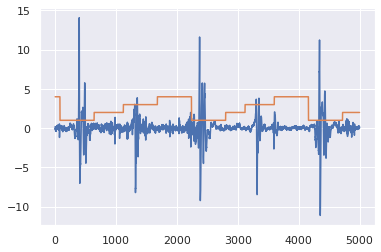

In [6]:
ex[0].shape
aux=ex[0]
plt.plot(aux[0,:5000]/1000)
plt.plot(aux[1,:5000])

### Segment data into pieces

In [7]:
L=2000
data_train_cut = data_train.map(cut_data)
data_test_cut = data_test.map(cut_data)
data_valid_cut = data_valid.map(cut_data)

### STFT transformation

#### This STFT transformed data (cut into 2000) will be used for FFN

In [22]:
frame_length=256
frame_step =32
data_train_stft = data_train_cut.map(lambda x: (tf.math.abs(tf.signal.stft(signals = x[0], frame_length = frame_length, frame_step = frame_step)), x[1]))
data_test_stft = data_test_cut.map(lambda x: (tf.math.abs(tf.signal.stft(signals = x[0], frame_length = frame_length, frame_step = frame_step)), x[1]))
data_valid_stft = data_valid_cut.map(lambda x: (tf.math.abs(tf.signal.stft(signals = x[0], frame_length = frame_length, frame_step = frame_step)), x[1]))

####  This STFT transformed data will be used for RNN, CNN, Transformers

In [9]:
data_size_var_train = data_train.map(lambda x: ((tf.shape(x)[1], tf.math.abs(tf.signal.stft(signals = x[0], frame_length = frame_length, frame_step = frame_step))), x[1]))
data_size_var_test = data_test.map(lambda x: ((tf.shape(x)[1], tf.math.abs(tf.signal.stft(signals = x[0], frame_length = frame_length, frame_step = frame_step))), x[1]))
data_size_var_valid = data_valid.map(lambda x: ((tf.shape(x)[1], tf.math.abs(tf.signal.stft(signals = x[0], frame_length = frame_length, frame_step = frame_step))), x[1]))

### Define batch size for segmented data

In [23]:
batch_size=2
input_train = data_train_stft.batch(batch_size)
input_test = data_test_stft.batch(batch_size)
input_valid = data_valid_stft.batch(batch_size)

# Define batch size and add padding for variable size data

In [54]:
batch_size = 2
k = 129 #shape of x

input_variable_train = data_size_var_train.padded_batch(batch_size, padded_shapes = (([], tf.TensorShape([None, k])), [None]))
input_variable_test = data_size_var_test.padded_batch(batch_size, padded_shapes = (([], tf.TensorShape([None, k])), [None]))
input_variable_valid = data_size_var_valid.padded_batch(batch_size, padded_shapes = (([], tf.TensorShape([None, k])), [None]))

### Check input shape for cut data

In [37]:
it1 = iter(input_variable_train)
ex1 = next(it1)
ex1 #input_train: shape=(2, 55, 129) data_size_var_train shape=(1493, 129), input_variable_train shape=(2, 1493, 129)

((<tf.Tensor: shape=(2,), dtype=int32, numpy=array([48000,  7868], dtype=int32)>,
  <tf.Tensor: shape=(2, 1493, 129), dtype=float32, numpy=
  array([[[2.47430878e+02, 7.78422607e+03, 5.55400781e+03, ...,
           3.46574059e+01, 6.97564087e+01, 4.06424255e+01],
          [3.00475146e+03, 8.23914648e+03, 7.98841064e+03, ...,
           4.47090950e+01, 6.33213692e+01, 8.73840332e+00],
          [7.54572144e+02, 1.01712500e+04, 1.16385645e+04, ...,
           5.70285950e+01, 6.35991859e+01, 2.09668884e+01],
          ...,
          [1.45487383e+04, 6.37698291e+03, 6.37474854e+03, ...,
           4.22628021e+01, 2.13667717e+01, 9.26171875e+00],
          [1.11278418e+04, 2.90557715e+03, 2.71550391e+03, ...,
           5.27793503e+01, 2.77494526e+01, 1.46879883e+01],
          [1.36672227e+04, 5.51294385e+03, 1.46977100e+03, ...,
           5.72983055e+01, 4.12233925e+01, 2.30976562e+01]],
  
         [[5.97128809e+03, 1.19678047e+04, 1.26185166e+04, ...,
           1.03938606e+02, 8.8617

### Define input shape

In [40]:
itera = tf.compat.v1.data.Iterator.from_structure(tf.compat.v1.data.get_output_types(input_train),
                                           tf.compat.v1.data.get_output_shapes(input_train))
train_init_op = itera.make_initializer(input_train)

features, labels = itera.get_next()
sample = itera.get_next()
sample
input_shape = np.shape((sample)[0])[1:]
print(input_shape)

(55, 129)


## Define variable input size

In [52]:
iterat = tf.compat.v1.data.Iterator.from_structure(tf.compat.v1.data.get_output_types(input_variable_train),
                                           tf.compat.v1.data.get_output_shapes(input_variable_train))
train_init_op2 = iterat.make_initializer(input_variable_train)

features2, labels2 = iterat.get_next()
sample2 = iterat.get_next()
sample2
#input_shape2 = np.shape((sample2)[1])[1] #48126
#input_shape2 = np.shape((sample2)[1])[0] #2
input_shape2 = np.shape((sample2)[1])[1:] #48126
print(input_shape2)

(48126,)


## FeedForward Neural network

Explain what was tried

### Defining hyperparameters

In [58]:
NUM_EPOCHS = 30 
INIT_LR  = 0.001 #change to 0.001 after
BS = 1 #batch size
opt= SGD(learning_rate=INIT_LR, momentum=0.9, decay=INIT_LR / NUM_EPOCHS)
opt2 = tf.optimizers.Adam(learning_rate = INIT_LR)

### Model

In [80]:
def feedforward_yes_upsampling_dense(opt, input_train, input_valid, input_test):
    model = Sequential() #object of sequencial class
    model.add(Flatten(input_shape=input_shape)) #we define the input shape, check shape after stft transformation
    model.add(Dense(4096))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(2048))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(1024))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(128)) 
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    #model.add(Dense(64)) 
   #model.add(BatchNormalization())
    #model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization()) # standardizes the inputs to a layer for each mini-batch. This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks
    #output layer
    model.add(Dense(100)) #because we have 4 y outputs, but also because it does not start at 0, we should reshape here to have an output of 10000 (2000x5)
    model.add(Activation("softmax"))

    model.add(Reshape((20, 5))) #output is all cut data (segment size) and target numbers
    model.add(UpSampling1D(100)) #tried 100 instead

    model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=['sparse_categorical_accuracy']) #multiclass classification problems, categorical crossentropy loss is the loss function of choice.

    history = model.fit(input_train, validation_data=input_valid,
                    batch_size=BS, 
                    epochs=NUM_EPOCHS)
    # plotting the metrics
    plt.subplot(2, 1, 1)
    plt.title('Sparse Crossentropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='val')
		# plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(history.history['sparse_categorical_accuracy'], color='blue', label='train')
    plt.plot(history.history['val_sparse_categorical_accuracy'], color='orange', label='val')
    score = model.evaluate(input_test, verbose=0) #evaluate based on test dataset, which was not used for training and validation
    return model.summary(), history, print('Loss using testing dataset=', score[0]), print('Accuracy using testing dataset=', score[1]) 


### Running the model

In [70]:
ffn=feedforward_yes_upsampling_dense(opt2, input_train, input_valid, input_test)

Epoch 1/30
1250/1250 [==============================] - 196s 152ms/step - loss: 1.4782 - sparse_categorical_accuracy: 0.3253 - val_loss: 1.6170 - val_sparse_categorical_accuracy: 0.3543
Epoch 2/30
1250/1250 [==============================] - 205s 164ms/step - loss: 1.3724 - sparse_categorical_accuracy: 0.3601 - val_loss: 1.4348 - val_sparse_categorical_accuracy: 0.3712
Epoch 3/30
1250/1250 [==============================] - 150s 120ms/step - loss: 1.3568 - sparse_categorical_accuracy: 0.3608 - val_loss: 1.4227 - val_sparse_categorical_accuracy: 0.3963
Epoch 4/30
1250/1250 [==============================] - 159s 127ms/step - loss: 1.3485 - sparse_categorical_accuracy: 0.3655 - val_loss: 1.4397 - val_sparse_categorical_accuracy: 0.3858
Epoch 5/30
1250/1250 [==============================] - 170s 136ms/step - loss: 1.3479 - sparse_categorical_accuracy: 0.3614 - val_loss: 1.5482 - val_sparse_categorical_accuracy: 0.3532
Epoch 6/30
 187/1250 [===>..........................] - ETA: 2:17 - lo

KeyboardInterrupt: ignored

## Recurrent Neural network

## Convolutional Neural network

In [53]:
inputs = Input(shape=(None,129),name='inputs')
inputs_all = Input(shape=[], name='inputs2')
inputs_variable=(inputs,inputs_all)

inputs_variable[0]

<KerasTensor: shape=(None, None, 129) dtype=float32 (created by layer 'inputs')>

In [81]:
def cnn_variable(opt, inputs, input_variable_valid,input_variable_test):
  inputs = Input(shape=(None,129),name='inputs')
  inputs_L = Input(shape=[],name='inputs2')
  layer_c = Conv1D(1024, 1, padding="same")(inputs)
  layer = Activation("LeakyReLU")(layer_c)
  layer = BatchNormalization(axis=-1)(layer)
  layer = Dropout(0.25)(layer)
  layer = Conv1D(512, 1, padding="same")(layer)
  layer = BatchNormalization(axis=-1)(layer)
  layer = Dropout(0.1)(layer)
  layer = Activation("LeakyReLU")(layer)
  layer = Conv1D(256, 1, padding="same")(layer)
  layer = BatchNormalization(axis=-1)(layer)
  layer = Dropout(0.1)(layer)
  layer = Activation("LeakyReLU")(layer)
  layer = Conv1D(128, 1, padding="same")(layer)
  layer = BatchNormalization(axis=-1)(layer)
  layer = Dropout(0.1)(layer)
  layer = Activation("LeakyReLU")(layer)
  layer = Conv1D(256, 1, padding="same")(layer)
  layer = BatchNormalization(axis=-1)(layer)
  layer = Activation("LeakyReLU")(layer)
  layer = Dropout(0.1)(layer)
  layer = MaxPooling1D(pool_size = 2)(layer)
  #layer = Flatten()(layer)
  #layer = Dropout(0.2)(layer)
  layer = TimeDistributed(Dense(1500))(layer)
  layer = Reshape((-1,5))(layer)
  layer = UpSampling1D(size=15)(layer)
  L = tf.cast(tf.reduce_max(inputs_L), tf.int32)
  output = layer[:,:L]
  model = Model(inputs = (inputs_L,inputs) , outputs=output)
  model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["sparse_categorical_accuracy"])
  history = model.fit(input_variable_train, validation_data=input_variable_valid, batch_size=BS, epochs=NUM_EPOCHS, verbose=1)
  # plotting the metrics
  plt.subplot(2, 1, 1)
  plt.title('Sparse Crossentropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='val')
	# plot accuracy
  plt.subplot(2, 1, 2)
  plt.title('Classification Accuracy')
  plt.plot(history.history['sparse_categorical_accuracy'], color='blue', label='train')
  plt.plot(history.history['val_sparse_categorical_accuracy'], color='orange', label='val')
  score = model.evaluate(input_variable_test, verbose=0) #evaluate based on test dataset, which was not used for training and validation
  return model.summary(), history, print('Loss using testing dataset=', score[0]), print('Accuracy using testing dataset=', score[1]) 

#### Run the model

In [77]:
cnn= cnn_variable(opt2, input_variable_train, input_variable_valid,input_variable_test)

Epoch 1/10
  76/1250 [>.............................] - ETA: 19:49 - loss: 5.3836 - sparse_categorical_accuracy: 0.2068

KeyboardInterrupt: ignored

## Transformers